<br><br><br>
# Questions
* Should we include cycle in our dataset?
* PCA?
* Time series analysis -> LSTM?

<br><br><br>

# 1. Import data, libaries and define global variables

In [29]:
import pandas as pd
import numpy as np
import os
import pickle
import time

# Allows us to navigate to files in parent folder
import sys
sys.path.append('..')

# Plot
import matplotlib.pyplot as plt

# Pre processing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
from keras import models, layers
from keras.layers import Dense, Activation
from keras.models import Sequential

In [30]:
df_training = pd.read_pickle("../data/df_training.pkl")
df_predict  = pd.read_pickle("../data/df_predict.pkl")

<br><br>
# 2. Split df_training and standardize

## 2.1 Split the df_training

In [94]:
def create_train_and_test_set(df, test_size, random_state = 1):
    """
    This function splits the data into a train and test set.
    """
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[2:-1]], 
                                                        df[df.columns[-1:]], 
                                                        test_size    = test_size, 
                                                        random_state = random_state)
    
    return X_train.values, X_test.values, y_train.values.ravel(), y_test.values.ravel()

def create_train_and_test_set_based_on_engineid(df, split_on_engineid):
    """
    This train test split splits the train and test data based on the engine id.
    So for example, if we split on engineid 80, we keep engineid <= 80 in the train set
    and 80 > in the test set.
    """
    
    train_df = df[df['engine_id'] <= split_on_engineid]
    test_df  = df[df['engine_id'] > split_on_engineid]
    
    X_train  = train_df[train_df.columns[2:-1]].values
    X_test   = test_df[test_df.columns[2:-1]].values
    y_train  = train_df[train_df.columns[-1:]].values.ravel()
    y_test   = test_df[test_df.columns[-1:]].values.ravel()
    
    
    return X_train, X_test, y_train, y_test

In [32]:
# Original train test split
X_train, X_test, y_train, y_test = create_train_and_test_set(df        = df_training, 
                                                             test_size = 0.20)

print('{} shape: {}'.format('X_train', X_train.shape))
print('{} shape: {}'.format('y_train', y_train.shape))
print('\n')
print('{} shape: {}'.format('X_test', X_test.shape))
print('{} shape: {}'.format('y_test', y_test.shape))

X_train shape: (16504, 16)
y_train shape: (16504,)


X_test shape: (4127, 16)
y_test shape: (4127,)


In [102]:
# Train test split based on engine id
X_train_engineid, X_test_engineid, y_train_engineid, y_test_engineid = create_train_and_test_set_based_on_engineid(df = df_training, 
                                                                                                                   split_on_engineid = 80)

print('{} shape: {}'.format('X_train_engineid', X_train_engineid.shape))
print('{} shape: {}'.format('y_train_engineid', y_train_engineid.shape))
print('\n')
print('{} shape: {}'.format('X_test_engineid', X_test_engineid.shape))
print('{} shape: {}'.format('y_test_engineid', y_test_engineid.shape))

X_train_engineid shape: (16138, 16)
y_train_engineid shape: (16138,)


X_test_engineid shape: (4493, 16)
y_test_engineid shape: (4493,)


## 2.2 Standardize

In [105]:
def standardize_data(X_train, X_test):
    """
    This function outputs standardized data.
    """
    # Fit the scaler on the X_train
    scaler  = StandardScaler().fit(X_train)
    
    # Transfor X_train and X_test
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # Return X_train_scaled and X_test_scaled
    return X_train_scaled, X_test_scaled

In [106]:
# Original train test split
X_train, X_test = standardize_data(X_train = X_train, X_test = X_test)

In [107]:
# Train test split based on engine id
X_train_engineid, X_test_engineid = standardize_data(X_train = X_train_engineid, X_test = X_test_engineid)

<br><br>
# 3. Predictors

In [108]:
def plot_residual_errors(model, X_train, X_test, y_train, y_test):
    """
    This function plots the residual errors.
    """    
    # Residual error in training data
    train_pred  = model.predict(X_train)
    train_error = train_pred - y_train.ravel()

    # Residual error in test data
    test_pred   = model.predict(X_test)
    test_error  = test_pred - y_test.ravel()
    
    # Plot the residual errors
    plt.scatter(train_pred, train_error, color = 'blue', label = 'Train data')
    plt.scatter(test_pred, test_error, color = 'green', label = 'Test data')
    plt.legend(loc = 'upper right') 
    plt.title("Residual errors") 
    plt.show()
    

def plot_predicted_vs_actual(model, X_test, y_test):
    """
    This function calculates the predicted vs actual rul.
    """

    # Residual error in test data
    test_pred   = model.predict(X_test)
    test_error  = test_pred - y_test.ravel()

    # Plot results
    fig, ax = plt.subplots()
    ax.scatter(test_pred, y_test, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    ax.set_xlabel('Predicted RUL')
    ax.set_ylabel('Actual RUL')
    ax.set_title(' Predicted RUL vs Actual RUL')
    plt.show()
    

def calculate_scores(model, X_train, X_test, y_train, y_test, print_results = True, extract_results = False):
    """
    This function calculates all the scores of the model. This includes:
    - MAE   = mean of the absolute value of the errors
    - MSE   = mean of the squared errors
    - RMSE  = square root of the mean of the squarred errors
    - R2    = proportion of the variance that is explained by the independent variables
    """    
    # Evaluation scores training data
    x_pred = model.predict(X_train)
    training_mae  = mean_absolute_error(y_train, x_pred)
    training_mse  = mean_squared_error(y_train, x_pred)
    training_rmse = np.sqrt(mean_squared_error(y_train, x_pred))
    training_r2   = r2_score(y_train, x_pred)
    
    # Evaluation scores test data
    y_pred = model.predict(X_test)
    test_mae      = mean_absolute_error(y_test, y_pred)
    test_mse      = mean_squared_error(y_test, y_pred)
    test_rmse     = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2       = r2_score(y_test, y_pred)
    
    if print_results == True:
        # Evaluation scores training data
        print('Evaluation metrics training data')
        print('mean_absolute_error:     ', training_mae)
        print('mean_squared_error:      ', training_mse)
        print('root_mean_squared_error: ', training_rmse)    
        print('r2_score:                ', training_r2)
        print('\n')

        # Evaluation scores test data
        print('Evaluation metrics test data')
        print('mean_absolute_error:     ', test_mae)
        print('mean_squared_error:      ', test_mse)
        print('root_mean_squared_error: ', test_rmse)
        print('r2_score:                ', test_r2)
        
    if extract_results == True:
        return {'training_mae'  : training_mae,
                'training_mse'  : training_mse,
                'training_rmse' : training_rmse,
                'training_r2  ' : training_r2,
                'test_mae'      : test_mae,
                'test_mse'      : test_mse,
                'test_rmse'     : test_rmse,
                'test_r2'       : test_r2}

## 3.1 Linear Regression

In [66]:
# Define LinearRegression object and fit it to our X_train, and y_train data
reg = LinearRegression()
reg.fit(X = X_train, y = y_train)

# Print out coefficients
coefDataFrame = pd.DataFrame(reg.coef_, df_training.columns[2:-1], columns=['Coefficients'])
print('Coefficients:')
display(coefDataFrame)

Coefficients:


,Coefficients
setting1,0.140414
setting2,0.290837
s2,-3.537200
s3,-2.589799
s4,-7.556364
s7,5.637008
s8,-0.844680
s9,-9.640969
s11,-10.184983
s12,7.443472


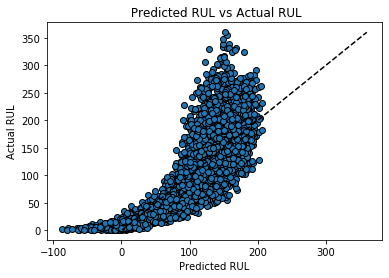

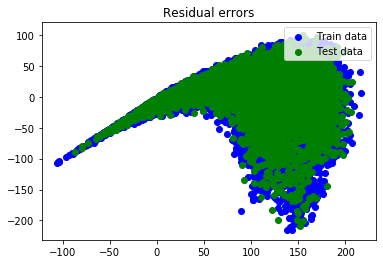

Evaluation metrics training data
mean_absolute_error:      34.194406919721175
mean_squared_error:       2004.812567180776
root_mean_squared_error:  44.77513335748735
r2_score:                 0.5757374320082382


Evaluation metrics test data
mean_absolute_error:      33.7896635868267
mean_squared_error:       1958.4656937590696
root_mean_squared_error:  44.254555627178874
r2_score:                 0.5936658719271541


In [67]:
plot_predicted_vs_actual(model = reg, X_test = X_test, y_test = y_test)
plot_residual_errors(model = reg, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
reg_results = calculate_scores(model = reg, extract_results = True, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

<br><br>

## 3.2 Decision Tree Regressor

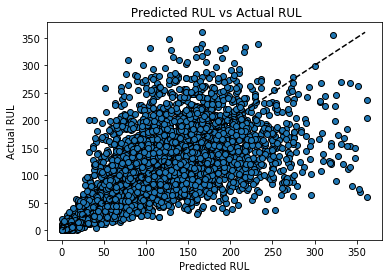

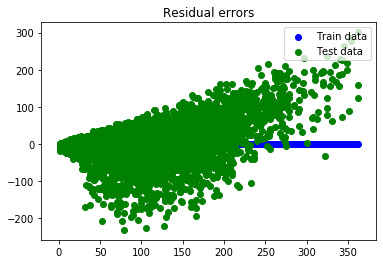

Evaluation metrics training data
mean_absolute_error:      0.0
mean_squared_error:       0.0
root_mean_squared_error:  0.0
r2_score:                 1.0


Evaluation metrics test data
mean_absolute_error:      40.897988853889025
mean_squared_error:       3423.7421856069786
root_mean_squared_error:  58.51275233320493
r2_score:                 0.28965654074613867


In [69]:
# Define regression model and fit it
tree_regressor = DecisionTreeRegressor(random_state=0)
tree_regressor.fit(X = X_train,
                   y = y_train)

# Plot results
plot_predicted_vs_actual(model = tree_regressor, X_test = X_test, y_test = y_test)
plot_residual_errors(model = tree_regressor, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
tree_regressor_results = calculate_scores(model = tree_regressor, extract_results = True, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

<br><br>

## 3.3 SVM

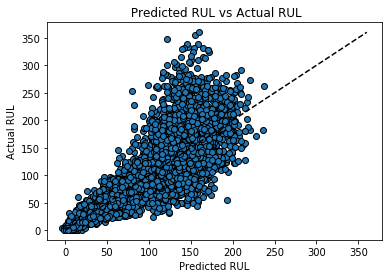

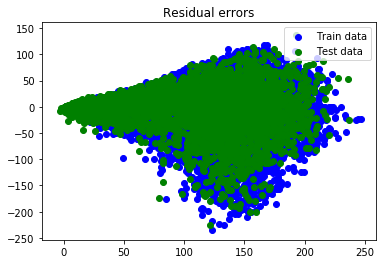

Evaluation metrics training data
mean_absolute_error:      24.853157370485413
mean_squared_error:       1536.7295344373076
root_mean_squared_error:  39.20114200424916
r2_score:                 0.674794128258092


Evaluation metrics test data
mean_absolute_error:      29.420149307778654
mean_squared_error:       1780.3677511422331
root_mean_squared_error:  42.19440426338821
r2_score:                 0.6306168751820944
Wall time: 49.9 s


In [71]:
%%time

# Define model
svr_rbf  = SVR(kernel  = 'rbf',    C = 100, gamma = 0.1, epsilon = .1)
svr_rbf.fit(X = X_train, y = y_train)

# Train svr and plot the results
plot_predicted_vs_actual(model = svr_rbf, X_test = X_test, y_test = y_test)
plot_residual_errors(model = svr_rbf, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
svr_rbf_results = calculate_scores(model = svr_rbf, extract_results = True, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

<br><br>

## 3.4 Random Forest (bagging)

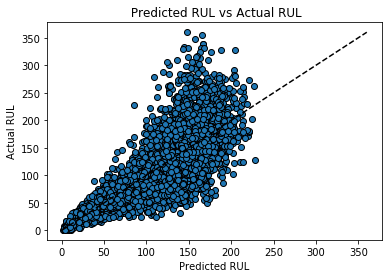

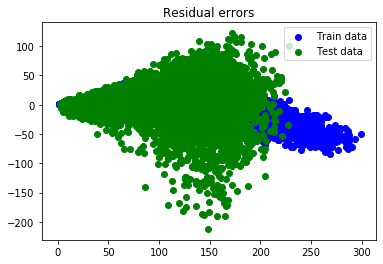

Evaluation metrics training data
mean_absolute_error:      10.962497576345129
mean_squared_error:       242.71991359670383
root_mean_squared_error:  15.579470902335029
r2_score:                 0.9486351115655239


Evaluation metrics test data
mean_absolute_error:      29.565386479282772
mean_squared_error:       1713.4892652047492
root_mean_squared_error:  41.394314406748535
r2_score:                 0.6444925388492377
Wall time: 15.5 s


In [73]:
%%time

# Define and fit random forest object
random_forest_regressor = RandomForestRegressor(random_state=0)
random_forest_regressor.fit(X = X_train, y = y_train)

# Plot results
plot_predicted_vs_actual(model = random_forest_regressor, X_test = X_test, y_test = y_test)
plot_residual_errors(model = random_forest_regressor, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
random_forest_regressor_results = calculate_scores(model = random_forest_regressor, extract_results = True, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

<br><br>

## 3.5 AdaBoost (boosting)

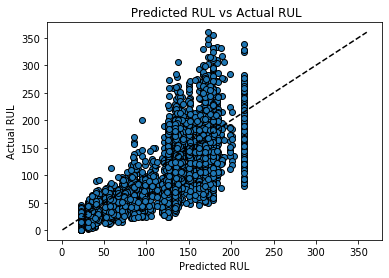

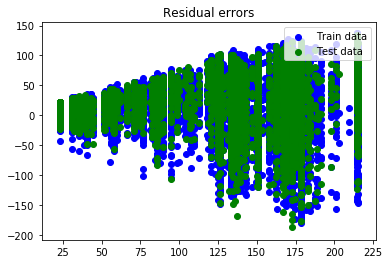

Evaluation metrics training data
mean_absolute_error:      36.17012944886846
mean_squared_error:       2131.0436824260455
root_mean_squared_error:  46.163228682860186
r2_score:                 0.5490241431995329


Evaluation metrics test data
mean_absolute_error:      36.6819864650709
mean_squared_error:       2158.8943003662653
root_mean_squared_error:  46.463903197711076
r2_score:                 0.5520817975335544
Wall time: 1.42 s


In [74]:
%%time

# Define and fit random forest object
adaboost = AdaBoostRegressor(random_state=0)
adaboost.fit(X = X_train, y = y_train)

# Plot results
plot_predicted_vs_actual(model = adaboost, X_test = X_test, y_test = y_test)
plot_residual_errors(model = adaboost, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
adaboost_results = calculate_scores(model = adaboost, extract_results = True, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

<br><br>

## 3.6 Gradient Boosting (boosting)

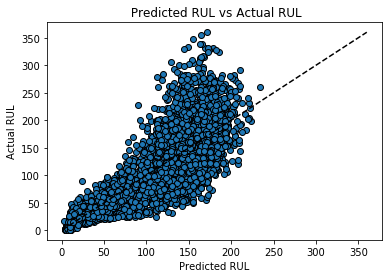

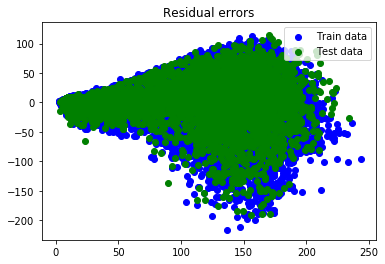

Evaluation metrics training data
mean_absolute_error:      28.709779639950547
mean_squared_error:       1618.176896638923
root_mean_squared_error:  40.2265695360532
r2_score:                 0.6575580695813427


Evaluation metrics test data
mean_absolute_error:      29.631041990083233
mean_squared_error:       1696.674276907878
root_mean_squared_error:  41.19070619578982
r2_score:                 0.6479812410664567
Wall time: 4.31 s


In [76]:
%%time

# Define and fit random forest object
gradboost = GradientBoostingRegressor(random_state=0)
gradboost.fit(X = X_train, y = y_train)

# Plot results
plot_predicted_vs_actual(model = gradboost, X_test = X_test, y_test = y_test)
plot_residual_errors(model = gradboost, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
gradboost_results = calculate_scores(model = gradboost, extract_results = True, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

<br><br>

## 3.7 XGBRegressor (boosting)

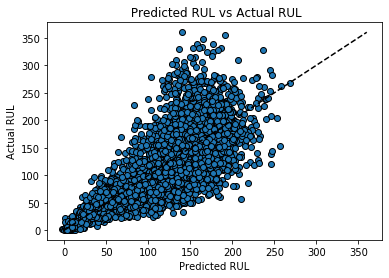

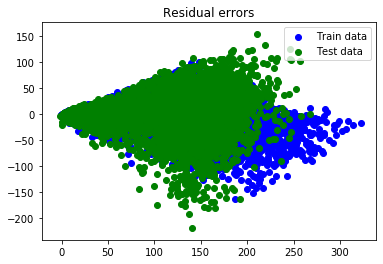

Evaluation metrics training data
mean_absolute_error:      18.88410042298906
mean_squared_error:       711.6304057996019
root_mean_squared_error:  26.67640166513471
r2_score:                 0.8494033066392215


Evaluation metrics test data
mean_absolute_error:      30.53555553635934
mean_squared_error:       1834.0715243089128
root_mean_squared_error:  42.826061274753165
r2_score:                 0.6194746448568746
Wall time: 1.82 s


In [77]:
%%time

# Define and fit random forest object
xgbr = xgb.XGBRegressor(random_state = 0) 
xgbr.fit(X = X_train, y = y_train)

# Plot results
plot_predicted_vs_actual(model = xgbr, X_test = X_test, y_test = y_test)
plot_residual_errors(model = xgbr, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
xgbr_results = calculate_scores(model = xgbr, extract_results = True, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

<br><br>

## 3.8 Neural Network

In [48]:
# Sequential model
model = models.Sequential() 

# Hidden layers
model.add(layers.Dense(units      = 128, 
                       activation ='relu',
                       input_dim  = X_train.shape[1]))
model.add(layers.Dense(units      = 128, 
                       activation = 'relu'))
model.add(layers.Dense(units      = 96, 
                       activation = 'relu'))
model.add(layers.Dense(units      = 64, 
                       activation ='relu'))
model.add(layers.Dense(units      = 1))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 96)                12384     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 37,345
Trainable params: 37,345
Non-trainable params: 0
_________________________________________________________________


In [50]:
%%time

X_train_nn = X_train[:-1000]
y_train_nn = y_train[:-1000]
X_val_nn   = X_train[-1000: ]
y_val_nn   = y_train[-1000: ]

history = model.fit(x               = X_train_nn, 
                    y               = y_train_nn, 
                    epochs          = 200,
                    validation_data = (X_val_nn, y_val_nn))


Train on 15504 samples, validate on 1000 samples
Epoch 1/200
15504/15504 [==============================] - 1s 57us/step - loss: 3035.0208 - mse: 3035.0220 - mae: 38.3450 - val_loss: 1979.5515 - val_mse: 1979.5516 - val_mae: 31.5022
Epoch 2/200
15504/15504 [==============================] - 1s 41us/step - loss: 1819.4040 - mse: 1819.4045 - mae: 30.5298 - val_loss: 1983.5886 - val_mse: 1983.5886 - val_mae: 30.4882
Epoch 3/200
15504/15504 [==============================] - 1s 40us/step - loss: 1758.7227 - mse: 1758.7223 - mae: 29.7897 - val_loss: 1899.9095 - val_mse: 1899.9094 - val_mae: 29.7822
Epoch 4/200
15504/15504 [==============================] - 1s 40us/step - loss: 1728.0153 - mse: 1728.0156 - mae: 29.4426 - val_loss: 1825.4015 - val_mse: 1825.4015 - val_mae: 30.0302
Epoch 5/200
15504/15504 [==============================] - 1s 42us/step - loss: 1735.4552 - mse: 1735.4548 - mae: 29.5267 - val_loss: 1870.7547 - val_mse: 1870.7549 - val_mae: 31.2782
Epoch 6/200
15504/15504 [=====

Epoch 44/200
15504/15504 [==============================] - 1s 41us/step - loss: 1388.1014 - mse: 1388.1010 - mae: 26.4086 - val_loss: 1957.9905 - val_mse: 1957.9906 - val_mae: 31.4446
Epoch 45/200
15504/15504 [==============================] - 1s 42us/step - loss: 1374.8724 - mse: 1374.8732 - mae: 26.3069 - val_loss: 1919.9138 - val_mse: 1919.9138 - val_mae: 31.0192
Epoch 46/200
15504/15504 [==============================] - 1s 40us/step - loss: 1353.4261 - mse: 1353.4260 - mae: 26.0617 - val_loss: 1958.6428 - val_mse: 1958.6426 - val_mae: 30.3045
Epoch 47/200
15504/15504 [==============================] - 1s 40us/step - loss: 1344.2354 - mse: 1344.2356 - mae: 25.9327 - val_loss: 1948.3153 - val_mse: 1948.3152 - val_mae: 30.8910
Epoch 48/200
15504/15504 [==============================] - 1s 40us/step - loss: 1323.0570 - mse: 1323.0576 - mae: 25.7395 - val_loss: 1955.7058 - val_mse: 1955.7058 - val_mae: 30.6945
Epoch 49/200
15504/15504 [==============================] - 1s 41us/step - 

Epoch 133/200
15504/15504 [==============================] - 1s 43us/step - loss: 277.4782 - mse: 277.4781 - mae: 12.1198 - val_loss: 2879.1762 - val_mse: 2879.1763 - val_mae: 36.7005
Epoch 134/200
15504/15504 [==============================] - 1s 41us/step - loss: 269.7786 - mse: 269.7786 - mae: 11.9338 - val_loss: 2949.6519 - val_mse: 2949.6516 - val_mae: 37.0343
Epoch 135/200
15504/15504 [==============================] - 1s 42us/step - loss: 264.8572 - mse: 264.8571 - mae: 11.9438 - val_loss: 2890.1064 - val_mse: 2890.1060 - val_mae: 36.9751
Epoch 136/200
15504/15504 [==============================] - 1s 41us/step - loss: 265.2271 - mse: 265.2271 - mae: 11.9055 - val_loss: 2867.0379 - val_mse: 2867.0383 - val_mae: 36.9603
Epoch 137/200
15504/15504 [==============================] - 1s 41us/step - loss: 263.7114 - mse: 263.7113 - mae: 11.8770 - val_loss: 2769.0301 - val_mse: 2769.0298 - val_mae: 35.9133
Epoch 138/200
15504/15504 [==============================] - 1s 46us/step - loss

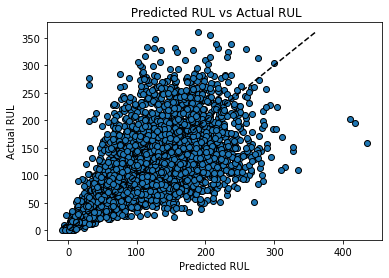

Evaluation metrics training data
mean_absolute_error:      9.776697720608201
mean_squared_error:       289.679672126483
root_mean_squared_error:  17.01997861709829
r2_score:                 0.9386973906671889


Evaluation metrics test data
mean_absolute_error:      37.7676659533323
mean_squared_error:       2922.378686433476
root_mean_squared_error:  54.05902964753877
r2_score:                 0.3936773060489992


In [51]:
# Plot results
plot_predicted_vs_actual(model = model, X_test = X_test, y_test = y_test)
# plot_residual_errors(model = model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)
calculate_scores(model = model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [52]:
history.history.keys()

dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])

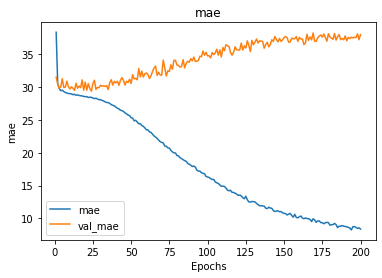

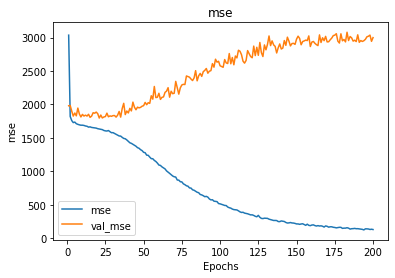

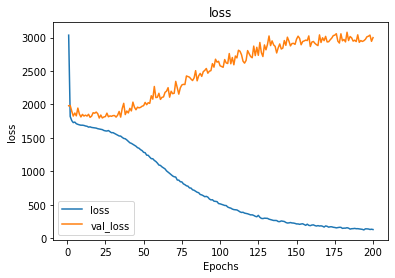

In [53]:
plt.plot(range(1, len(history.history['mae']) + 1), history.history['mae'])
plt.plot(range(1, len(history.history['val_mae']) + 1), history.history['val_mae'])
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('mae')
plt.legend(['mae', 'val_mae'])
plt.show();

plt.plot(range(1, len(history.history['mse']) + 1), history.history['mse'])
plt.plot(range(1, len(history.history['val_mse']) + 1), history.history['val_mse'])
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.title('mse')
plt.legend(['mse', 'val_mse'])
plt.show();

plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('loss')
plt.legend(['loss', 'val_loss'])
plt.show();

<br><br>
# 4. Summarize

In [ ]:
all_results = [reg_results, tree_regressor_results, svr_rbf_results, 
               random_forest_regressor_results, adaboost_results, 
               gradboost_results, xgbr_results, history]